# Mini Project: Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [84]:
%matplotlib inline

In [85]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [86]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [87]:
# player sum, dealer showing card, whether or not usable Ace
# 0 stick, 1 hit

In [88]:
for i_episode in range(3):
    state = env.reset()
    print(state)
    while True:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        print(state)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(13, 10, False)
(13, 10, False)
End game! Reward:  -1.0
You lost :(

(20, 7, False)
(22, 7, False)
End game! Reward:  -1
You lost :(

(16, 10, False)
(16, 10, False)
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [89]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [90]:
# state, action, reward
for i in range(3):
    print(generate_episode_from_limit(env))

[((21, 5, True), 0, 1.0)]
[((13, 1, False), 1, -1)]
[((17, 6, False), 1, -1)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [91]:
import numpy as np
import sys
from collections import Counter
from collections import defaultdict

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = Counter()
    num_visits = Counter()
    V = Counter()
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # monte-carlo learning
        episode = generate_episode(env)
        first_visits = set()
        acc_return = 0
        for state, action, reward in episode[::-1]:
            if state not in first_visits:
                first_visits.add(state)
                # calculate return, update counters
                ret = reward + gamma * acc_return
                returns[state] += ret
                num_visits[state] += 1
                # accumulate
                acc_return += reward
                # discount
                acc_return *= gamma
                
    V = {}
    for state, ret in returns.items():
        V[state] = ret / num_visits[state]

    return V

In [92]:
# how to deal with first visits?
# need to wait until end of episode
# is there a better way of doing this? check code later, don't influence now


Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

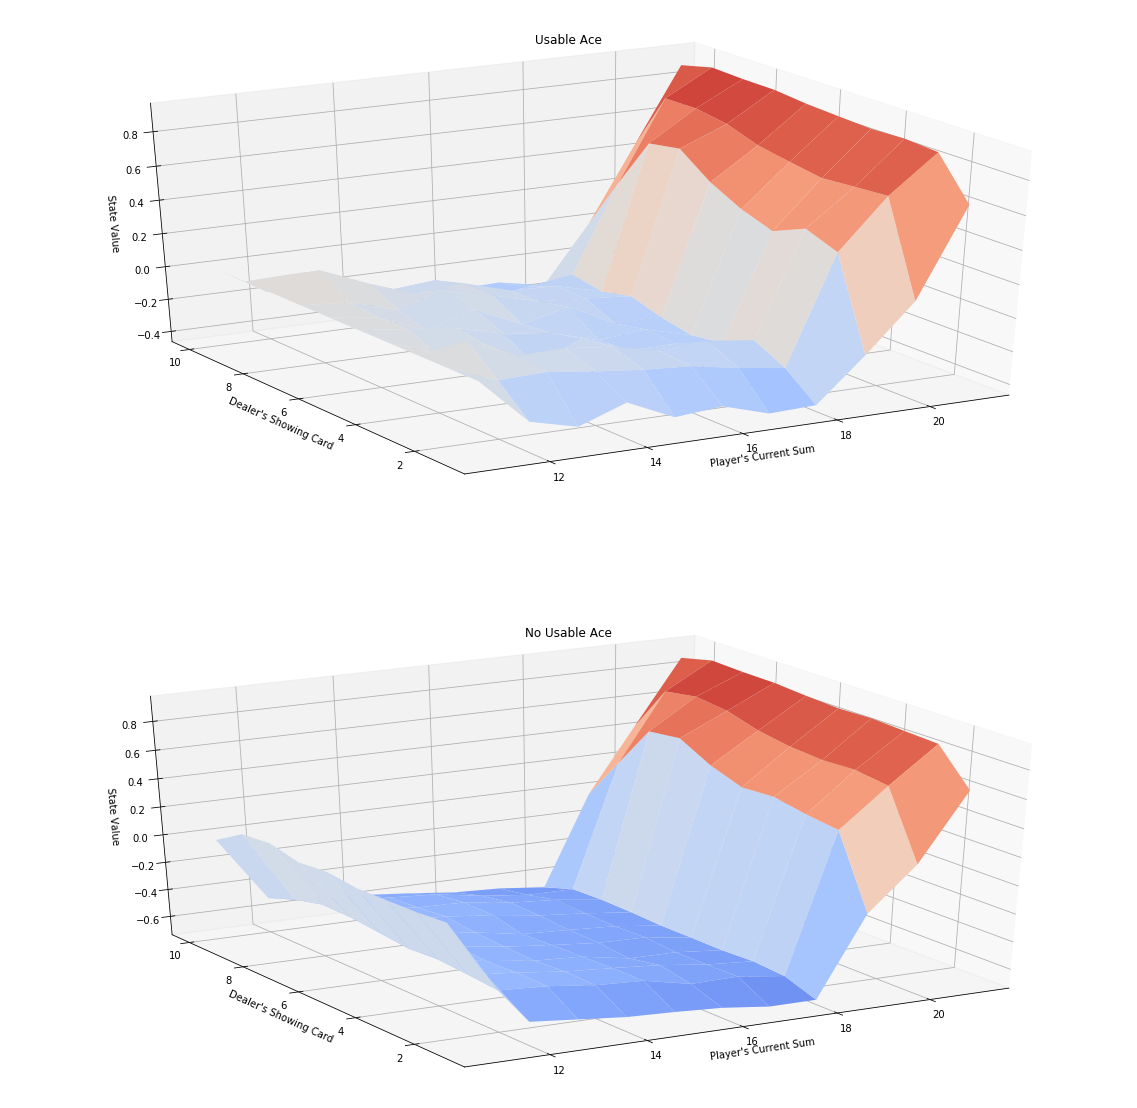

In [93]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [94]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [95]:
from collections import defaultdict
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    # other approach? use an array. but I don't know the complete list of possible states
    # neither they have a particular order
    returns = defaultdict(lambda: np.zeros(env.action_space.n))
    num_visits = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # monte-carlo learning
        episode = generate_episode(env)
        first_visits = set()
        acc_return = 0
        for state, action, reward in episode[::-1]:
            if state not in first_visits:
                first_visits.add((state, action))
                # calculate return, update counters
                ret = reward + gamma * acc_return
                returns[state][action] += ret
                num_visits[state][action] += 1
                # accumulate
                acc_return += reward
                # discount
                acc_return *= gamma
                
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for state, actions in returns.items():
        for action, ret in enumerate(actions):            
            Q[state][action] = ret / num_visits[state][action]

    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

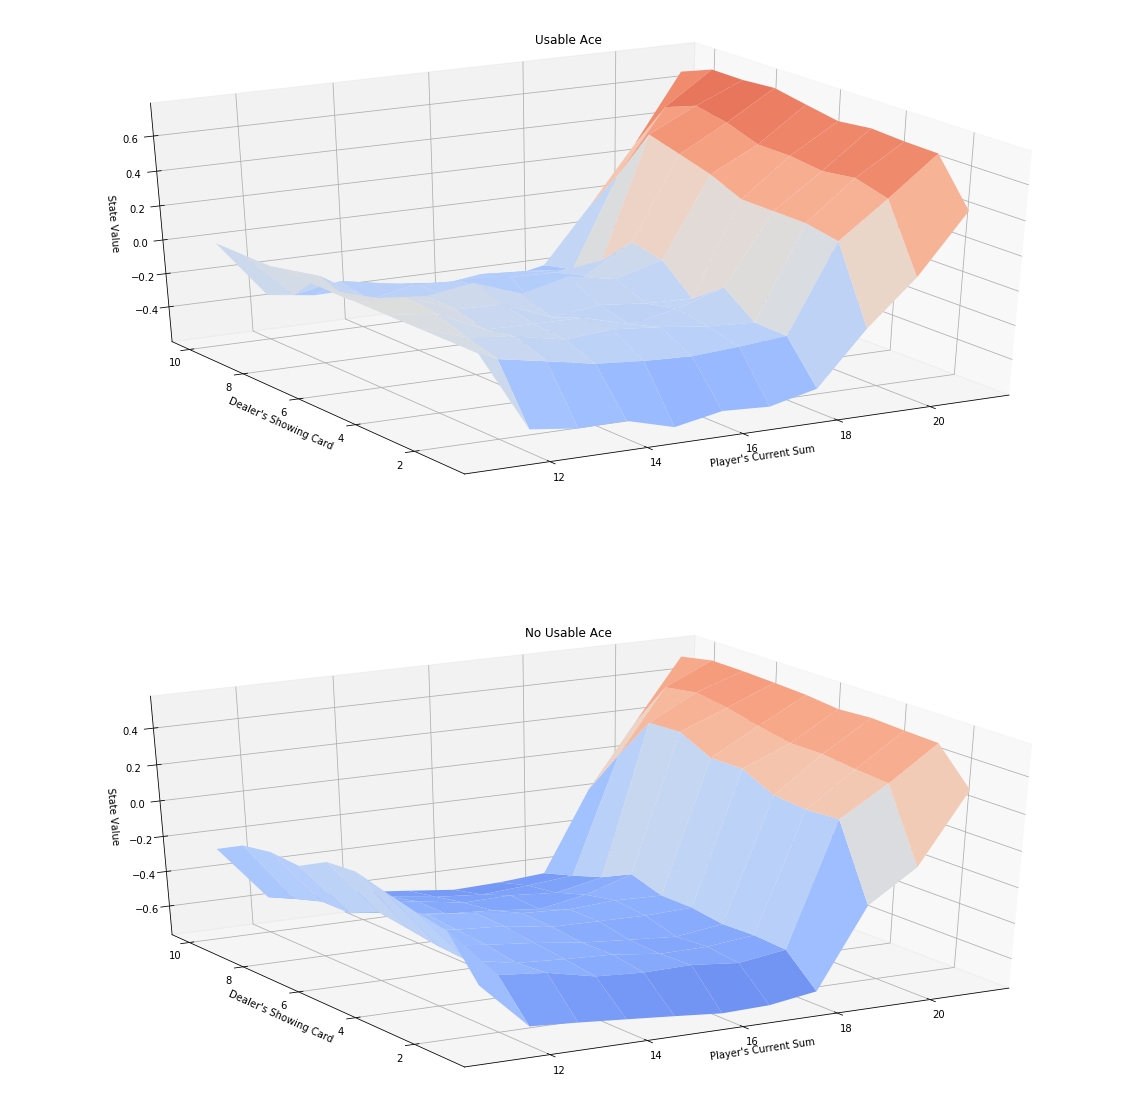

In [96]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 3: MC Control: GLIE

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [97]:
def mc_control_GLIE(env, num_episodes, gamma=1.0, epsilon=0.2):

    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    A = range(env.action_space.n)
    policy = defaultdict(lambda: np.random.choice(A))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate episode
        episode = []
        state = env.reset()
        
        # navigate environment until end of episode
        done = False
        while not done:
            action = policy[state]
            next_state, reward, done, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # monte-carlo learning - i nitialize variables        
        first_visits = set()
        acc_return = 0

        # iterate, evaluate and improve
        for state, action, reward in episode[::-1]:
            if state not in first_visits:
                ### Evaluation
                first_visits.add((state, action))
                # calculate return, update num visits counter
                ret = reward + gamma * acc_return
                N[state][action] += 1
                # accumulate and discount for next
                acc_return += reward
                acc_return *= gamma
                
                ### Improvement
                current_q = Q[state][action]
                Q[state][action] = current_q + (ret-current_q)/N[state][action]
                
        # update policy
        for state in Q.keys():
            if np.random.random() < epsilon:
                policy[state] = np.random.choice(A)
            else:
                policy[state] = np.argmax(Q[state])
                
    # report final optimal policy, no e-greedy
    for state in Q.keys():
        policy[state] = np.argmax(Q[state])
                
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [98]:
# taking a lot longer because I'm estimating the polocy as well in each episode
# reduced from 500,000 runs to 20,000 runs

In [99]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 50000, epsilon=0.3)

Episode 50000/50000.

Next, we plot the corresponding state-value function.

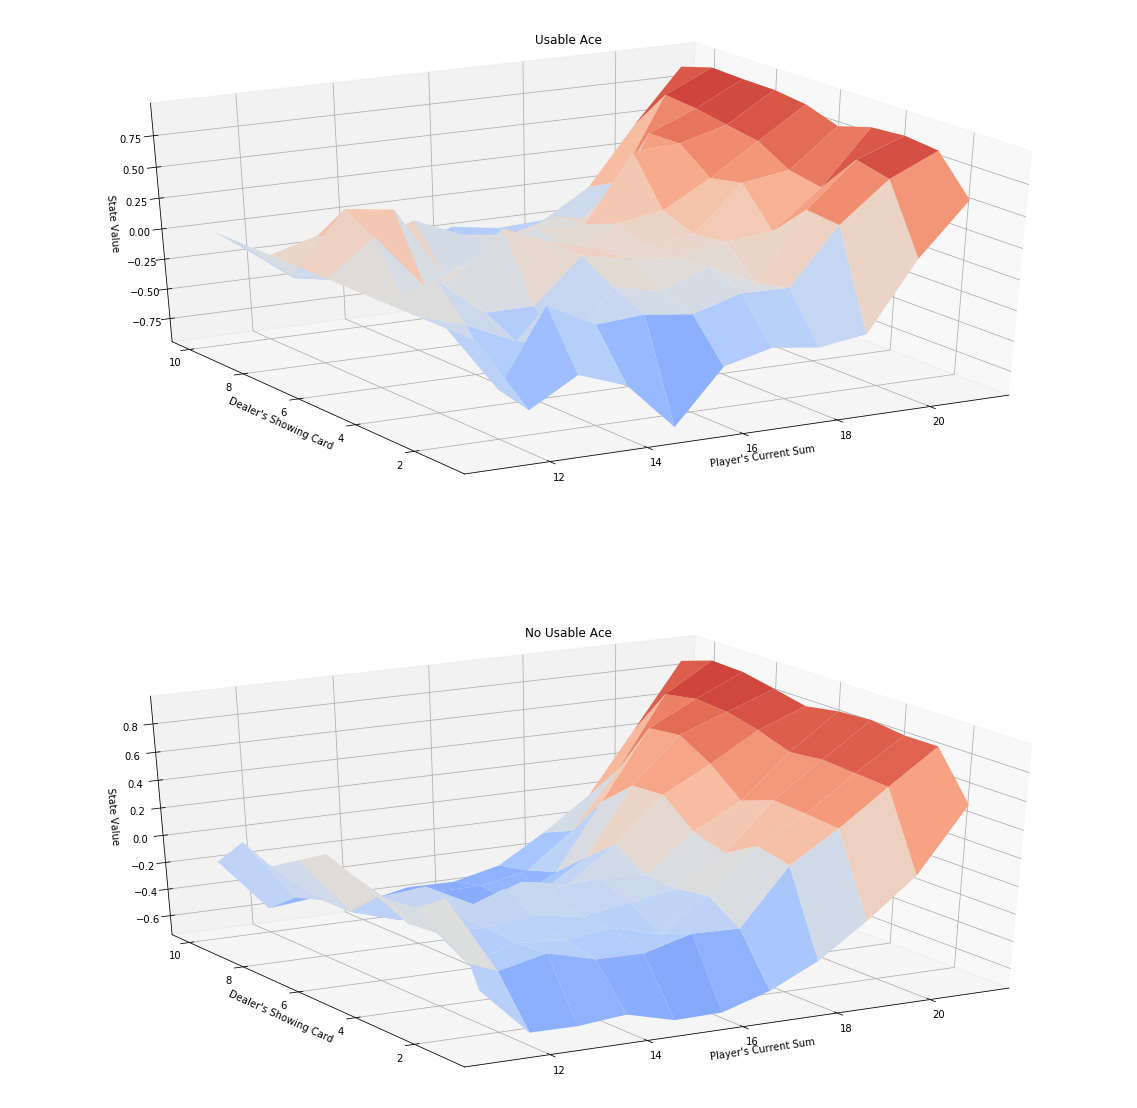

In [100]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

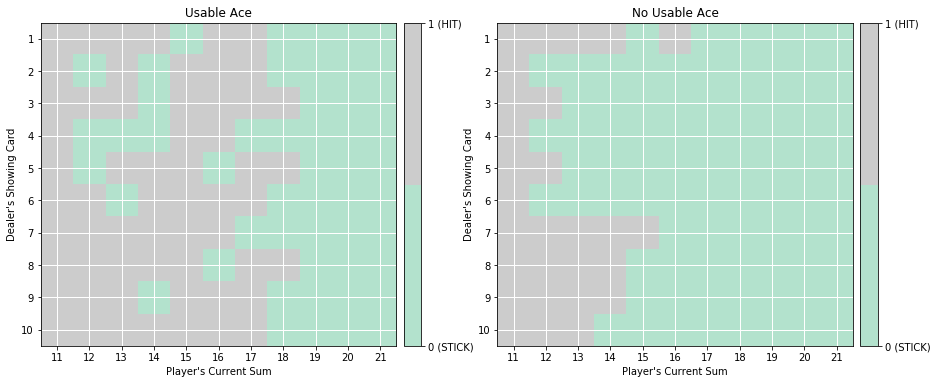

In [101]:
# from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

### Part 4: MC Control: Constant-$\alpha$

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [108]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0, epsilon=1):

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    A = range(env.action_space.n)
    policy = defaultdict(lambda: np.random.choice(A))
    base_epsilon = epsilon
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # decay epsilon. manually set slower decay than e/i, too agressive
        epsilon = base_epsilon/((i_episode//100)+1)        

        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate episode
        episode = []
        state = env.reset()
        
        # navigate environment until end of episode
        done = False
        while not done:
            action = policy[state]
            next_state, reward, done, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # monte-carlo learning - i nitialize variables        
        first_visits = set()
        acc_return = 0

        # iterate, evaluate and improve
        for state, action, reward in episode[::-1]:
            if state not in first_visits:
                ### Evaluation
                first_visits.add((state, action))
                # calculate return, update num visits counter
                ret = reward + gamma * acc_return
                # accumulate and discount for next
                acc_return += reward
                acc_return *= gamma
                
                ### Improvement
                current_q = Q[state][action]
                Q[state][action] = current_q + alpha*(ret - current_q)
                
        # update policy
        for state in Q.keys():
            if np.random.random() < epsilon:
                policy[state] = np.random.choice(A)
            else:
                policy[state] = np.argmax(Q[state])
                
    # report final optimal policy, no e-greedy
    for state in Q.keys():
        policy[state] = np.argmax(Q[state])
                
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [109]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 50000, 0.008)

Episode 50000/50000.

Next, we plot the corresponding state-value function.

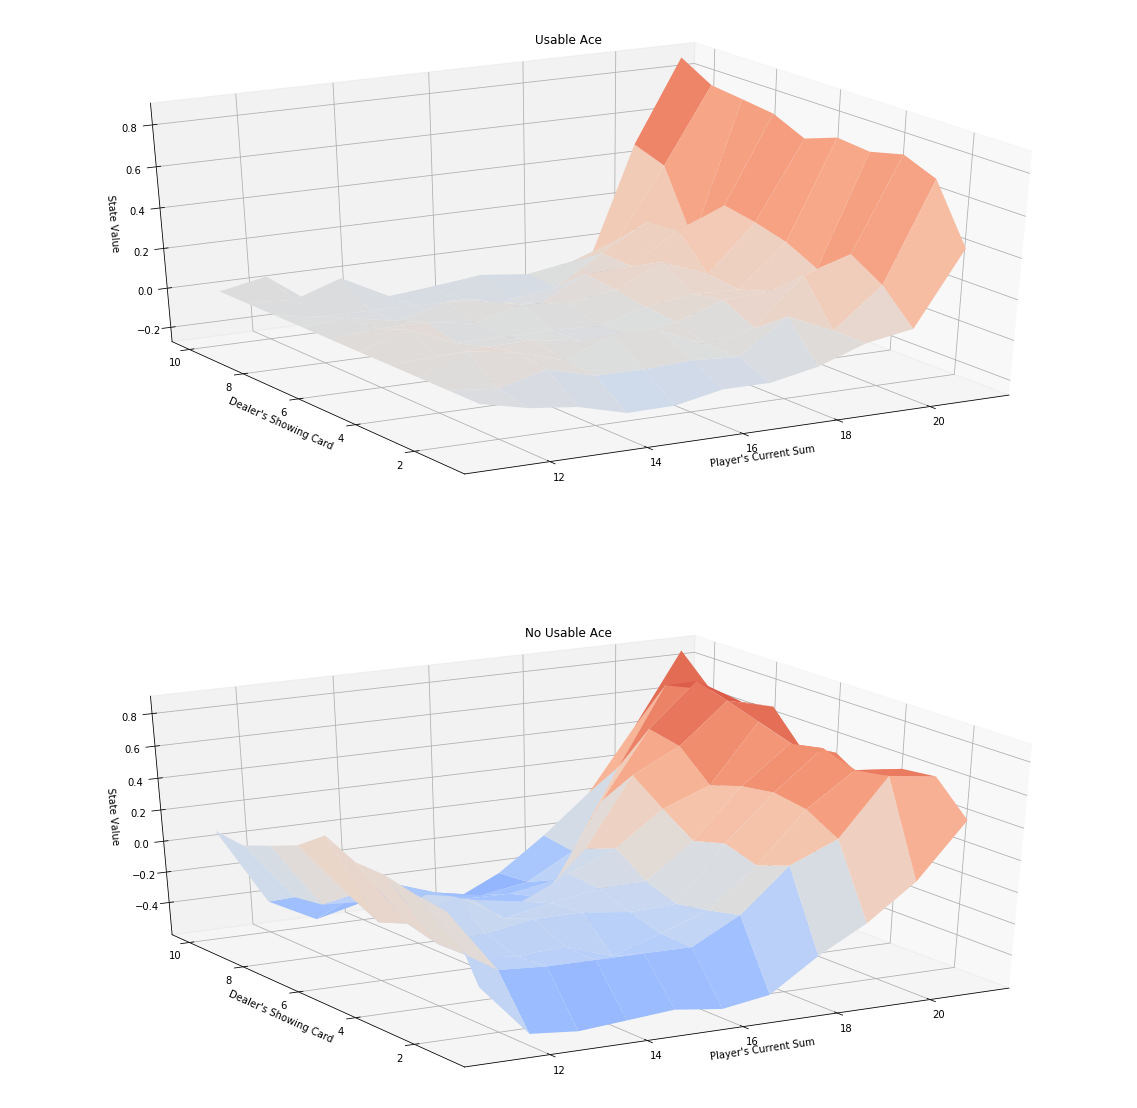

In [110]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

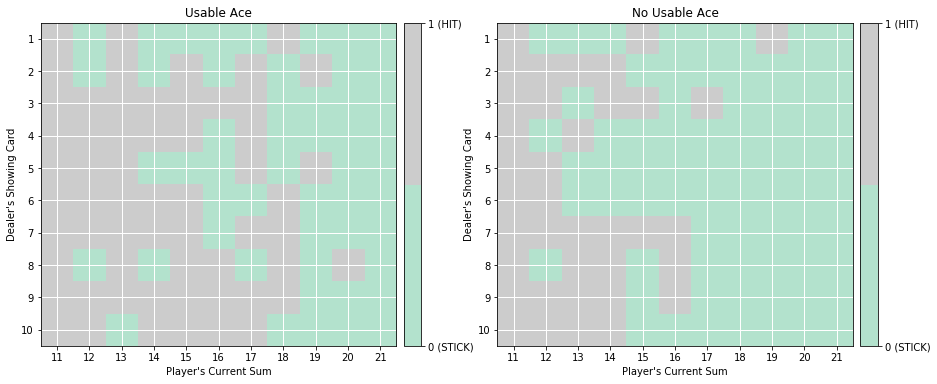

In [111]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)